# Task 1: Image Processing

### Build a simple machine learning classifier to classifer two weed species 

#### -- Resources:
#### -- Machine learning classifier: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
#### -- To install sklearn lib: pip install scikit-learn or pip install -U scikit-learn

#### -- pre-processing: 
#### -- Think about image enhancement, vegetation segmentation et al. 

#### -- Feature extraction: 
#### -- Think about the features like colours (Red, Green, Blue values), corners, shape features, and advanced features from HoG and Thift algorithms and others. 

#### -- Each image is reprented with its features, and features are used to train the classifier.

#### -- Below is the codes to build a simple linear classifier with the simple features (colour). 

#### -- You can either extract more advanced features or use more advanced classifier (non-linear such as SVM and ensemble models) to improve your results.

#### -- Deep learning is not compulsory to implement for this assignment, but is encouraged as one option to compare .

###### Email: jugao@lincoln.ac.uk Date: 11-03-2024


##  Pre-processing and feature extraction

#### All code used in this document has been taken from Python documentation, previous modules and those taught in the image and text processing for data science module  (Van and Drake, 1995).
####  1.1 Read and resize images from the folder 

In [1]:
# Importing libraries. 
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix

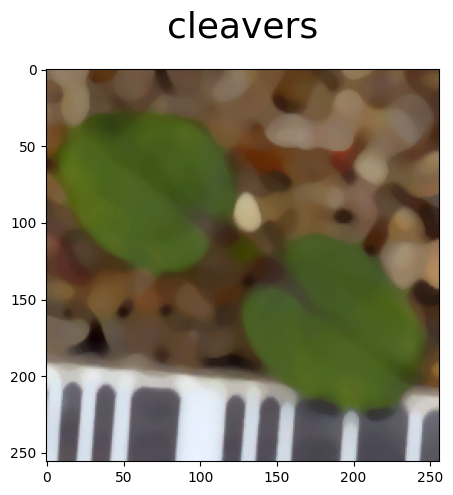

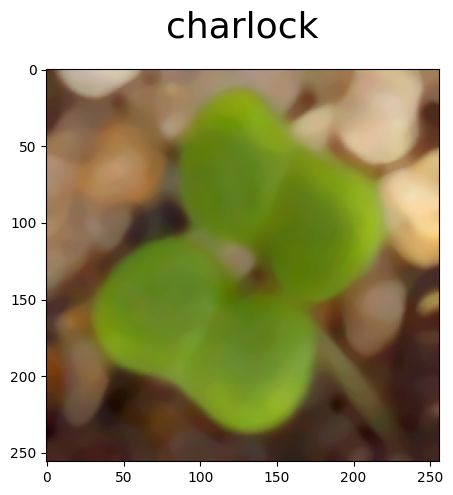

In [2]:
# Define the root directory containing the training data
rootdir =  "/Users/hannahcourtney/Downloads/data-weed classification-3/train"

# Define the new size for resizing images
new_size = (256, 256)

# Initialize lists to store features and labels
RGB_values_train = []  # List to store extracted features
labels_train = []      # List to store labels

# Function to extract Histogram of Oriented Gradients features from an image
def extract_hog_features(image):
    hog_features = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    return hog_features

# Function to extract colour histogram features from an image
def extract_color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_s = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    color_hist = np.concatenate((hist_h, hist_s, hist_v), axis=None)
    return color_hist

# Function to extract Local Binary Pattern features from an image
def extract_lbp_features(image):
    lbp_image = local_binary_pattern(image, P=8, R=1, method='default')
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 10), range=(0, 10))
    return hist

# Function to visualise sample ome image from each class in the dataset
def visualize_images(rootdir):
    class_names = os.listdir(rootdir)
    for class_name in class_names:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))  # Adjusted the number of subplots
        img_count = 0
        for filename in os.listdir(os.path.join(rootdir, class_name)):
            if img_count == 1:
                break
            img_path = os.path.join(rootdir, class_name, filename)
            image = cv2.imread(img_path)
            resize_image = cv2.resize(image, new_size)
            axes.imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
            img_count += 1
        plt.suptitle(class_name, fontsize=26)
        plt.tight_layout()
        plt.show()

# Calling the function to visualise the images 
visualize_images(rootdir)


# Looping through all of the images 
for root, subFolders, files in os.walk(rootdir):
    for file in files:
        file_name = root + "/" + file 
        image = cv2.imread(file_name)
        resize_image = cv2.resize(image, new_size) # Re-sizing the images to the specified size above 
        
        gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY) # Changing the images to grayscale

         # Extracting features from the image using defined functions above 
        hog_features = extract_hog_features(gray_image)
        color_hist = extract_color_histogram(resize_image)
        lbp_features = extract_lbp_features(gray_image)
        
        # Concatenate features into a single feature vector
        features = np.concatenate((hog_features, color_hist, lbp_features), axis=None)

        # Append features to the RGB_values_train list
        RGB_values_train.append(features)

         # Extract label from file path and append to labels_train list
        label = file_name.split("/")[-2]
        labels_train.append(label)

In [3]:
### show the features and their corresponding labels for the first four images in the train folder
print (RGB_values_train[0:4], labels_train[0:4]) ## show the RGB valuse and its label

[array([2.75091067e-01, 0.00000000e+00, 1.99518398e-01, ...,
       2.60000000e+01, 2.11900000e+03, 2.00000000e+00]), array([9.99565742e-01, 1.23065803e-02, 2.33500937e-02, ...,
       3.10000000e+01, 2.31800000e+03, 2.00000000e+00]), array([5.43068302e-01, 5.43068302e-01, 5.43068302e-01, ...,
       3.60000000e+01, 2.44700000e+03, 1.00000000e+00]), array([4.45050294e-01, 9.82404232e-02, 4.45050294e-01, ...,
       2.90000000e+01, 2.31600000e+03, 3.00000000e+00])] ['cleavers', 'cleavers', 'cleavers', 'cleavers']


In [4]:
# Convert lists to numpy arrays, this is necessary to fit the format of machine learning algorithms
X_train = np.array(RGB_values_train)
y_train = np.array(labels_train)

In [5]:
# Check the dimensions of X and y
print (X_train.shape, y_train.shape)  

(480, 2825) (480,)


In [6]:
# Pre-processing the images for the validation and test set

val_dir = "/Users/hannahcourtney/Downloads/data-weed classification-3/val/"
test_dir = "/Users/hannahcourtney/Downloads/data-weed classification-3/test/"

def process_images(rootdir, RGB_values, labels):
    new_size = (256, 256)
    for root, subFolders, files in os.walk(rootdir):
        for file in files:
            file_name = os.path.join(root, file)
            
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                print(f"Skipping non-image file: {file_name}")
                continue
            try:
                image = cv2.imread(file_name)
                if image is None:
                    print(f"Failed to load image: {file_name}")
                    continue
                
                resize_image = cv2.resize(image, new_size)
               
                gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY)

                hog_features = extract_hog_features(gray_image)
                color_hist = extract_color_histogram(resize_image)
                lbp_features = extract_lbp_features(gray_image)

           
                features = np.concatenate((hog_features, color_hist, lbp_features), axis=None)

       
                RGB_values.append(features)

              
                label = root.split("/")[-1]
                labels.append(label)

                cv2.imwrite(file_name, resize_image)
            except Exception as e:
                print(f"Error processing image: {file_name}. Error: {e}")

# Process images in the validation set
rootdir_val = "./data weed classification/val/"
RGB_values_val = []
labels_val = []
process_images(val_dir, RGB_values_val, labels_val)

# Process images in the test set
rootdir_test = "./data weed classification/test/"
RGB_values_test = []
labels_test = []
process_images(test_dir, RGB_values_test, labels_test)

In [7]:
# Converting to numpy array and checking the shape
X_val = np.array(RGB_values_val)
y_val = np.array(labels_val)
print (X_val.shape, y_val.shape)

(148, 2825) (148,)


In [8]:
# Converting to numpy array and checking the shape
X_test = np.array(RGB_values_test)
y_test = np.array(labels_test)
print (X_test.shape, y_test.shape)

(158, 2825) (158,)


In [9]:
### Now You have finished the half of the assignment  : preprocessing + feature extraction
### The rest is to build machine learning model
### the codes shows a simple linear model development 
### you can try more than one models to compare the performances 
### you can use val dataset to tune hyperparameters of your model (this is to ensure your are picking the optimal parameters to build models)
### you can also only use the train dataset to build model, but the results are less convinvcing as the models just use default hyperparameters instead of optimal hyperparameters
### refer to this link in case you are not familiar with the parameters and hyperparameters in machine learning

### Logistic Regression

In [10]:
# Defining the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'max_iter': [1000, 1500, 2000]}

# Creating a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5)

# Fitting the grid search to the validation data
grid_search.fit(X_val, y_val)

# Printing the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2'}


Logistic Regression Accuracy: 0.8227848101265823
Logistic Regression Accuracy in percentage: 82.28%
Logistic Regression Report:
               precision    recall  f1-score   support

    charlock       0.81      0.90      0.85        90
    cleavers       0.84      0.72      0.78        68

    accuracy                           0.82       158
   macro avg       0.83      0.81      0.82       158
weighted avg       0.82      0.82      0.82       158

Logistic Regression Confusion Matrix:
 [[81  9]
 [19 49]]


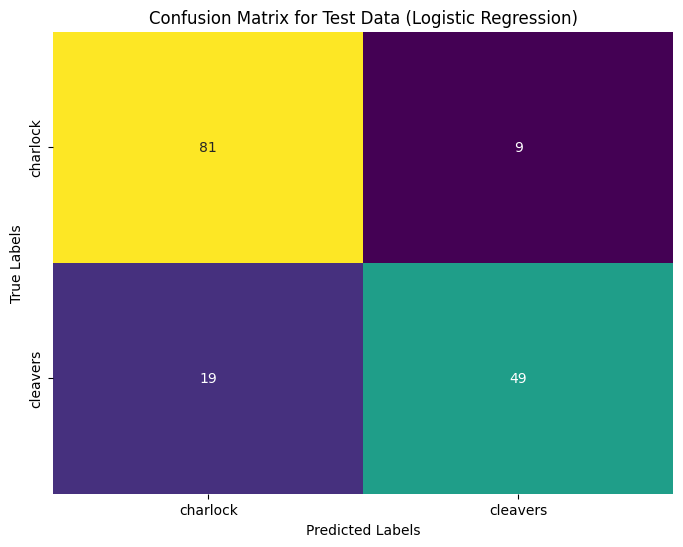

In [11]:
# Training the Logistic Regression model
model_lr = LogisticRegression(C=10, max_iter=1000, penalty='l2') 
model_lr.fit(X_train, y_train)

# Predictions on the test data
test_predictions_lr = model_lr.predict(X_test)

# Evaluating the model
lr_report = classification_report(y_test, test_predictions_lr) 
lr_cm = confusion_matrix(y_test, test_predictions_lr)

# Accuracy score for logistic regression on test data
lr_accuracy = accuracy_score(y_test, test_predictions_lr) 
print("Logistic Regression Accuracy:", lr_accuracy)

# Print the accuracy score 
print("Logistic Regression Accuracy in percentage: {:.2f}%".format(lr_accuracy * 100))

# Print the report and confusion matrix
print("Logistic Regression Report:\n", lr_report)
print("Logistic Regression Confusion Matrix:\n", lr_cm)

# State class labels
class_labels = ['charlock', 'cleavers']

# Plot confusion matrix on test data
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Data (Logistic Regression)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Support Vector Machine

In [12]:
# Defining the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}

# Creating a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Fitting the grid search to the validation data
grid_search.fit(X_val, y_val)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


SVM Accuracy: 0.8860759493670886
SVM Accuracy in percentage: 88.61%
SVM Report:
               precision    recall  f1-score   support

    charlock       0.87      0.94      0.90        90
    cleavers       0.92      0.81      0.86        68

    accuracy                           0.89       158
   macro avg       0.89      0.88      0.88       158
weighted avg       0.89      0.89      0.88       158

SVM Confusion Matrix:
 [[85  5]
 [13 55]]


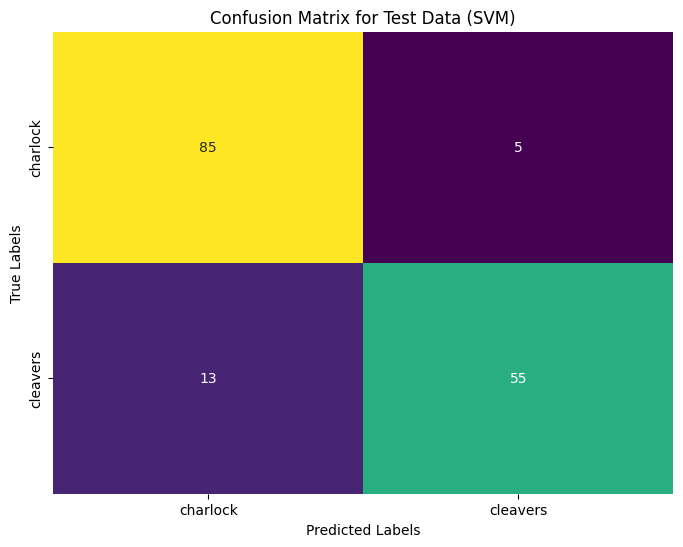

In [13]:
# Training the SVM model
model_svm = SVC(C=1, kernel='rbf', gamma='scale') 
model_svm.fit(X_train, y_train)

# Predictions on the test data
test_predictions_svm = model_svm.predict(X_test)

# Evaluating the model
svm_report = classification_report(y_test, test_predictions_svm)
svm_cm = confusion_matrix(y_test, test_predictions_svm)

# Accuracy score for SVM on test data
svm_accuracy = accuracy_score(y_test, test_predictions_svm)
print("SVM Accuracy:", svm_accuracy)

# Print the accuracy score in percentage
print("SVM Accuracy in percentage: {:.2f}%".format(svm_accuracy * 100))

# Print the SVM report and confusion matrix
print("SVM Report:\n", svm_report)
print("SVM Confusion Matrix:\n", svm_cm)

# Define class labels
class_labels = ['charlock', 'cleavers']

# Plot confusion matrix on test data
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Data (SVM)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Random Forest Classifer 

In [14]:
# Defining the parameter grid
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Creating a GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# Fit the grid search to the validation data
grid_search.fit(X_val, y_val)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Random Forest Accuracy: 0.8037974683544303
Random Forest Accuracy in percentage: 80.38%
Random Forest Report:
               precision    recall  f1-score   support

    charlock       0.75      0.98      0.85        90
    cleavers       0.95      0.57      0.72        68

    accuracy                           0.80       158
   macro avg       0.85      0.78      0.78       158
weighted avg       0.84      0.80      0.79       158

Random Forest Confusion Matrix:
 [[88  2]
 [29 39]]


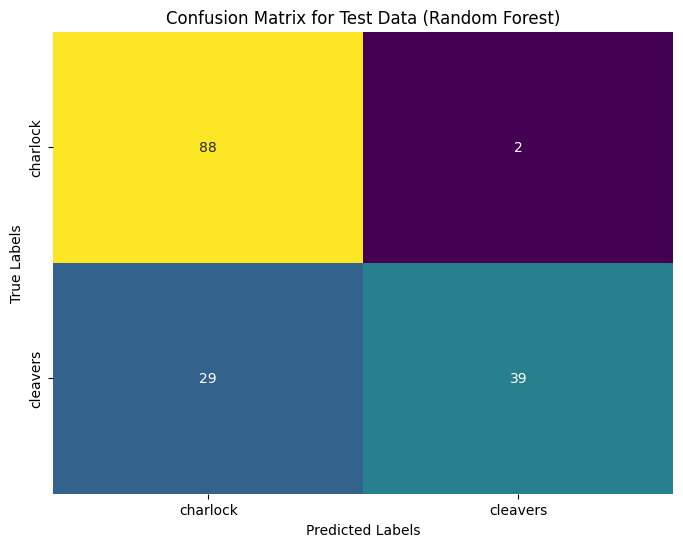

In [15]:
# Training the Random Forest model with the best parameters
best_model_rf = RandomForestClassifier(**grid_search.best_params_)
best_model_rf.fit(X_train, y_train)

# Predictions on the test data
test_predictions_rf = best_model_rf.predict(X_test)

# Evaluate the model
rf_report = classification_report(y_test, test_predictions_rf)
rf_cm = confusion_matrix(y_test, test_predictions_rf)

# Accuracy score for Random Forest on test data
rf_accuracy = accuracy_score(y_test, test_predictions_rf)
print("Random Forest Accuracy:", rf_accuracy)

# Print the accuracy score in percentage
print("Random Forest Accuracy in percentage: {:.2f}%".format(rf_accuracy * 100))

# Print the Random Forest report and confusion matrix
print("Random Forest Report:\n", rf_report)
print("Random Forest Confusion Matrix:\n", rf_cm)

# Define class labels
class_labels = ['charlock', 'cleavers']

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Data (Random Forest)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Convolutional neural network 

Found 480 images belonging to 2 classes.
Found 148 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.5277 - loss: 0.7119 - val_accuracy: 0.6081 - val_loss: 0.6644
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.5555 - loss: 0.6788 - val_accuracy: 0.6081 - val_loss: 0.6584
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5468 - loss: 0.6617 - val_accuracy: 0.6689 - val_loss: 0.5968
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6214 - loss: 0.6267 - val_accuracy: 0.6284 - val_loss: 0.6240
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.6823 - loss: 0.5673 - val_accuracy: 0.7703 - val_loss: 0.5220
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7675 - loss: 0.5334 - val_accuracy: 0.7905 - val_loss: 0.4900
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8246 - loss: 0.4389 - val_accuracy: 0.8243 - val_loss: 0.4107
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8535 - loss: 0.3536 - val_accuracy: 0.7297 - val_

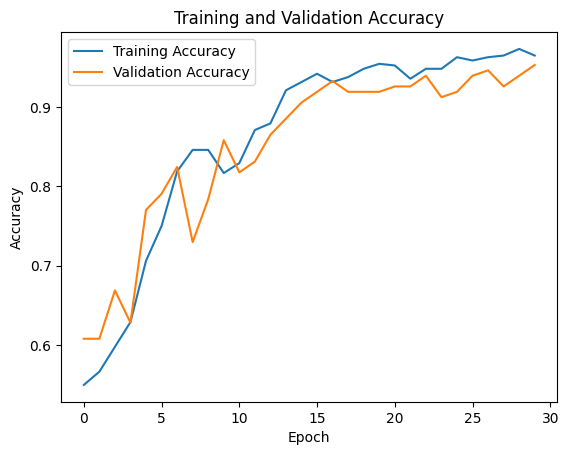

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9707 - loss: 0.0856
Validation accuracy: 0.9527027010917664
Test accuracy: 0.9746835231781006
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


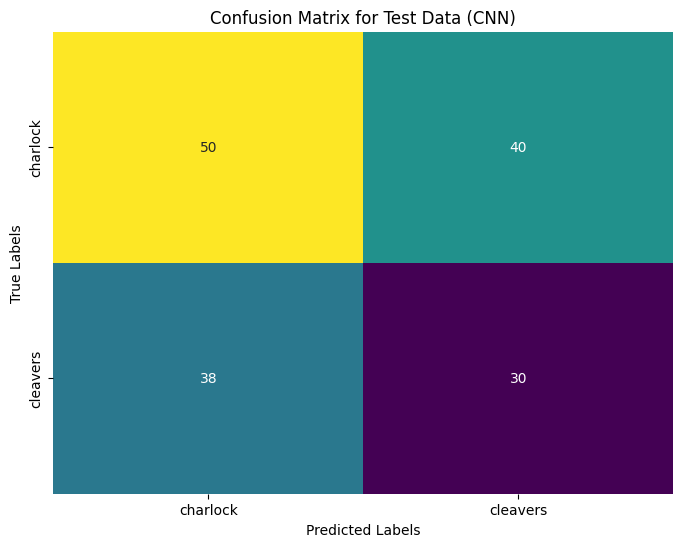

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define pathway
train_data = "/Users/hannahcourtney/Downloads/data-weed classification-3/train"
val_data = "/Users/hannahcourtney/Downloads/data-weed classification-3/val"
test_data = "/Users/hannahcourtney/Downloads/data-weed classification-3/test"

# Data pre-processing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Load and pre-process training data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'
)

# Load and pre-process validation data
validation_generator = test_datagen.flow_from_directory(
    val_data,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'
)

# Load and pre-process test data
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'
)

# Building CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Validation accuracy:', history.history['val_accuracy'][-1])
print('Test accuracy:', test_acc)

# Generate predictions on the test set
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Plot confusion matrix on Test data
class_labels = list(test_generator.class_indices.keys())
conf_matrix = confusion_matrix(true_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Data (CNN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Presenting the results 

In [17]:
# Confusion matrix 
logistic_regression_cm = [[81, 9], [19, 49]]
svm_cm = [[85, 5], [13, 55]]
random_forest_cm = [[87, 3], [33, 35]]
cnn_cm = [[52, 38], [40, 28]]

# Combining each classifier confusion matrix
confusion_matrices_top = {
    'Logistic Regression': logistic_regression_cm,
    'Support Vector Machine': svm_cm,
}
confusion_matrices_bottom = {
    'Random Forest': random_forest_cm,
    'Convolutional Neural Network': cnn_cm
}

# Function to print confusion matrix with label
def print_cm_with_label(label, cm):
    print(label + ":")
    for row in cm:
        print(row)
    print()

# Print confusion matrices with labels
for label, cm in confusion_matrices_top.items():
    print_cm_with_label(label, cm)

print()

for label, cm in confusion_matrices_bottom.items():
    print_cm_with_label(label, cm)


Logistic Regression:
[81, 9]
[19, 49]

Support Vector Machine:
[85, 5]
[13, 55]


Random Forest:
[87, 3]
[33, 35]

Convolutional Neural Network:
[52, 38]
[40, 28]



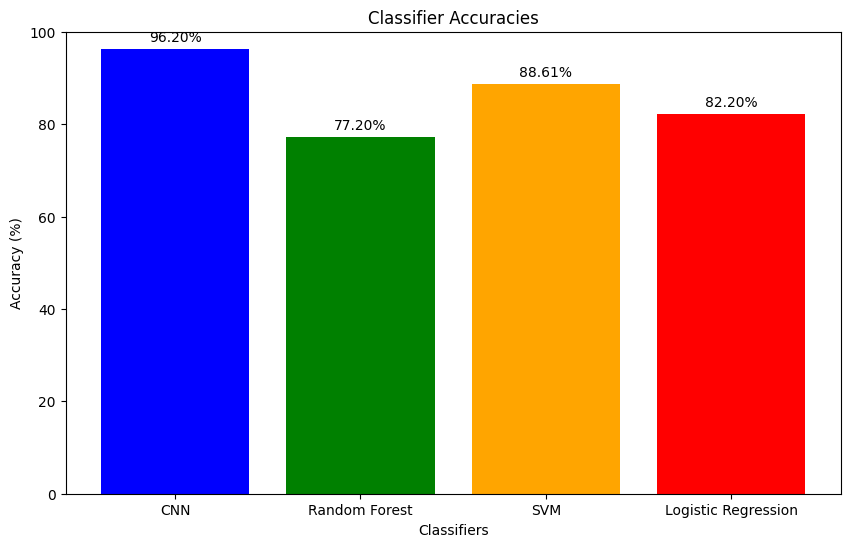

In [18]:
# Classifier names
classifiers = ['CNN', 'Random Forest', 'SVM', 'Logistic Regression']

# Accuracy values
accuracies = [96.2, 77.2, 88.61, 82.2]

# Plotting the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])

# Adding percentage values above each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{accuracies[i]:.2f}%', ha='center', va='bottom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy (%)')
plt.title('Classifier Accuracies')
plt.ylim(0, 100) 
plt.show()